## Part 2: Finetuning pretrained CNN on the downstream task
In this part, you will finetune a pretrained CNN model to another task. Finetuning is powerful with the following strengths:
1. **Faster training** : It starts with pre-trained weights which allow the model to converge faster than training from scratch.
2. **Domain Adaptation** : Fine-tuning is effective for adapting a model trained on one domain to another.
3. **Transfer Learning**...and more

In this part, you will finetune on BDD weather classifcation dataset, more details here: https://www.kaggle.com/datasets/marquis03/bdd100k-weather-classification

### Tasks
1. Follow the steps and complete your finetuning procedure
2. Compare the training/val loss/accuracy curve between training from scratch and finetuning
3. Plot the confusion matrix for two cases

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split
from torch import Tensor
from typing import Type
from torchvision.datasets import ImageFolder

# Visualizations
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import os
import pdb

import kagglehub

### [0 points] Step 1: Download the BDD100K weather classification dataset from Kaggle
Please DO NOT modify this cell.

In [2]:
# Download BDD weather classification dataset
base_dir = kagglehub.dataset_download("marquis03/bdd100k-weather-classification")
print("Path to dataset files:", base_dir)
train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'val')

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Path to dataset files: /home/saijaideepreddymure/.cache/kagglehub/datasets/marquis03/bdd100k-weather-classification/versions/1


### [5 points] Step 2: Create the data loader, and split it to train/val

Basically this step is the same as you did in Part 1.
Remember to change the ```num_classes``` to 7, and we will only train for 10 epochs.

1. The original folder structure is: \
   ├── train \
│   ├── labels (such as clear, foggy...) \
│   │   ├── *****.jpg \
│   │   ├── *****.jpg \
│   │   ├── ... \
   It is highly recommended to use ```dataset.ImageFolder``` to load the data!
2. To check how to transform your data, check here: https://pytorch.org/vision/main/transforms.html
3. Later when you train the model, you might need to tune hyperparameters. For example, you may not want the fixed learning rate.


In [13]:
image_size = 64
learning_rate = 0.01
batch_size = 32
num_epochs =10
num_classes = 7 

train_transforms = transforms.Compose([
    transforms.Resize((image_size,image_size)),
    transforms.ToTensor()
])
test_transform = transforms.Compose([
    transforms.Resize((image_size,image_size)),
    transforms.ToTensor()
])

train_data = ImageFolder(root = train_dir,transform = train_transforms)
test_data = ImageFolder(root = test_dir,transform = test_transform)

train_size = int(0.8 * len(train_data))
val_size = len(train_data) - train_size
train_data, val_data = random_split(train_data,[train_size,val_size])


train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)


### [5 points] Step 3: Copy your CNN model and training function in Part 1 after this cell

In [4]:
import torch
import torch.nn as nn

class yourCNN(nn.Module):
    def __init__(self, num_classes=200):
        super(yourCNN, self).__init__()

        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.fc_layers = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),  # Global pooling
            nn.Flatten(),
            nn.Linear(512, 1024),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x

 


In [5]:
model = yourCNN(num_classes = num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

### [15 points] Step 4: Compare the difference of finetuning from pretrained model and training from scratch
1. You will need to finetune two models. The first is the model trained from scratch with the BDD dataset, and another is finetuning from pretrained model.
2. For training from scratch, it is almost the same procedure as in Part 1, but the dataset changes.
3. For finetuning, the procedure is:
   * Initialize the model and load the pretrained model using ```torch.load()```, remember that we saved the trained model in Part 1!
   * The output of original CNN is 200 classes, you might need to reinitialize the model to output 7 classes by replacing the last fc layer
   * More details : https://pytorch.org/tutorials/beginner/basics/saveloadrun_tutorial.html

In [6]:
### Training function
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=num_epochs):
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(num_epochs):
        model.train()
        #############################################################
        #                      Your code here                       #
        #############################################################
        train_loss = 0.0
        train_accuracy = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            train_accuracy += (predicted == labels).sum().item() / len(labels) # Calculate accuracy for the batch
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {train_loss/len(train_loader):.4f}, Accuracy: {train_accuracy/len(train_loader):.4f}")

        train_loss /= len(train_loader)
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy / len(train_loader)) # Store average batch accuracy



        ### Validation
        model.eval()
        #############################################################
        #                      Your code here                       #
        #############################################################
        val_loss = 0.0
        val_accuracy = 0.0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                val_accuracy += (predicted == labels).sum().item() / len(labels) # Calculate accuracy for the batch

        val_loss /= len(val_loader)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy / len(val_loader)) # Store average batch accuracy
        print(f"Epoch {epoch+1}/{num_epochs}, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy/len(val_loader):.4f}")


    return train_losses, val_losses, train_accuracies, val_accuracies, model

Epoch 1/10, Loss: 1.2695, Accuracy: 0.5643
Epoch 1/10, Validation Loss: 1.3113, Validation Accuracy: 0.5442
Epoch 2/10, Loss: 1.1956, Accuracy: 0.5895
Epoch 2/10, Validation Loss: 1.1584, Validation Accuracy: 0.5725
Epoch 3/10, Loss: 1.1763, Accuracy: 0.5925
Epoch 3/10, Validation Loss: 1.1616, Validation Accuracy: 0.5917
Epoch 4/10, Loss: 1.1689, Accuracy: 0.5951
Epoch 4/10, Validation Loss: 1.1596, Validation Accuracy: 0.5896
Epoch 5/10, Loss: 1.1588, Accuracy: 0.5942
Epoch 5/10, Validation Loss: 1.1251, Validation Accuracy: 0.6094
Epoch 6/10, Loss: 1.1429, Accuracy: 0.6016
Epoch 6/10, Validation Loss: 1.1020, Validation Accuracy: 0.5965
Epoch 7/10, Loss: 1.1189, Accuracy: 0.6156
Epoch 7/10, Validation Loss: 1.0967, Validation Accuracy: 0.6059
Epoch 8/10, Loss: 1.1141, Accuracy: 0.6182
Epoch 8/10, Validation Loss: 1.1269, Validation Accuracy: 0.6130
Epoch 9/10, Loss: 1.1027, Accuracy: 0.6220
Epoch 9/10, Validation Loss: 1.0681, Validation Accuracy: 0.6362
Epoch 10/10, Loss: 1.1040, A

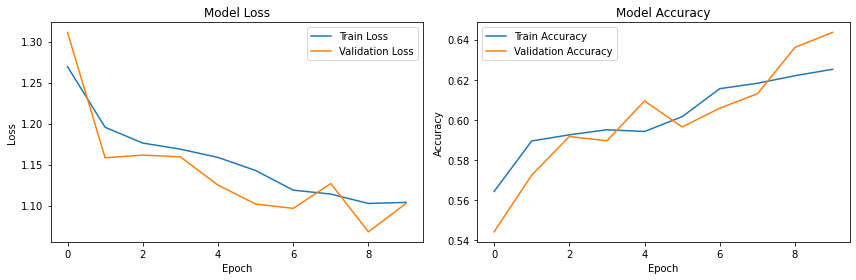

In [7]:
### Train the model
train_losses, val_losses, train_accuracies, val_accuracies, model = train_model(model, train_loader, val_loader, criterion, optimizer)

### We will save the model, in part 2 we gonna use it!
torch.save(model.state_dict(), 'BDD_weights_full_dataset.pth')

### Plot results. This is a naive plot, you are encouraged to improve it!
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

### [0 points] Step 5: Start training the model!

In [ ]:
import torch
import torch.nn as nn

# Define the original CNN architecture
class yourCNN(nn.Module):
    def __init__(self, num_classes=200):  # Original num_classes=200
        super(yourCNN, self).__init__()

        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.fc_layers = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),  # Global pooling
            nn.Flatten(),
            nn.Linear(512, 1024),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)  # Last layer
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x


# Load the pre-trained model
model_ft = yourCNN(num_classes=200)  # Define model with original 200 classes
model_ft.load_state_dict(torch.load("CNN_weights_full_dataset.pth"))  # Load weights

# Modify the last layer for 7 classes
in_features = model_ft.fc_layers[-1].in_features  # Get last layer input size
model_ft.fc_layers[-1] = nn.Linear(in_features, 7)  # Change to 7 classes

# Move model to GPU/CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_ft = model_ft.to(device)

# **Do NOT freeze any layers** (Train everything)
for param in model_ft.parameters():
    param.requires_grad = True  # Ensure all layers are trainable

# Define optimizer and loss function
optimizer = torch.optim.Adam(model_ft.parameters(), lr=0.001)  # Train all params
criterion = nn.CrossEntropyLoss()

# Print modified model
print(model_ft)


yourCNN(
  (conv_layers): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU()
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(

Epoch 1/10, Loss: 0.9145, Accuracy: 0.6924
Epoch 1/10, Validation Loss: 0.7744, Validation Accuracy: 0.7400
Epoch 2/10, Loss: 0.7480, Accuracy: 0.7509
Epoch 2/10, Validation Loss: 0.7109, Validation Accuracy: 0.7575
Epoch 3/10, Loss: 0.6777, Accuracy: 0.7741
Epoch 3/10, Validation Loss: 0.8229, Validation Accuracy: 0.7137
Epoch 4/10, Loss: 0.6075, Accuracy: 0.7961
Epoch 4/10, Validation Loss: 0.7392, Validation Accuracy: 0.7539
Epoch 5/10, Loss: 0.5359, Accuracy: 0.8193
Epoch 5/10, Validation Loss: 0.7507, Validation Accuracy: 0.7609
Epoch 6/10, Loss: 0.4411, Accuracy: 0.8502
Epoch 6/10, Validation Loss: 0.8397, Validation Accuracy: 0.7561
Epoch 7/10, Loss: 0.3542, Accuracy: 0.8789
Epoch 7/10, Validation Loss: 0.9025, Validation Accuracy: 0.7336
Epoch 8/10, Loss: 0.2759, Accuracy: 0.9061
Epoch 8/10, Validation Loss: 1.0969, Validation Accuracy: 0.7249
Epoch 9/10, Loss: 0.2132, Accuracy: 0.9284
Epoch 9/10, Validation Loss: 1.0989, Validation Accuracy: 0.7355
Epoch 10/10, Loss: 0.1695, A

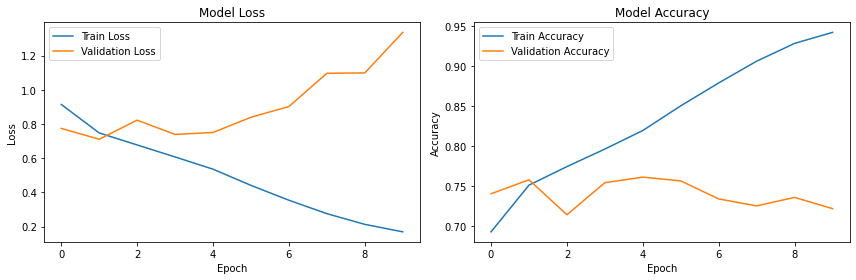

In [ ]:
### Train the model
train_losses, val_losses, train_accuracies, val_accuracies, model = train_model(model_ft, train_loader, val_loader, criterion, optimizer)

### We will save the model, in part 2 we gonna use it!
torch.save(model_ft.state_dict(), 'BDD_weights_full_dataset_transfer.pth')

### Plot results. This is a naive plot, you are encouraged to improve it!
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

### [5 points] Step 6: Evaluate your model on testing set and plot the confusion matrix
In this part, you will learn to evaluate a trained model on testing set, and plot the confusion matrix.
Ideally, a great classification model would have non-zero values only along the diagonal, with zeros in all off-diagonal elements.

**HINTS**
1. Remember to perform the same transforms to your testing set as the validation set.
2. In ```get_predictions```, it is basically the same as you do evaluation.

In [15]:
model.load_state_dict(torch.load('BDD_weights_full_dataset.pth'))

# Change model to evaluation phase
model.eval()

# Function to get predictions and true labels
def get_predictions(model, dataloader):
    #############################################################
    #                      Your code here                       #
    #############################################################
    all_predictions = []
    all_labels = []
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    return np.array(all_predictions), np.array(all_labels)


### Get predictions and true labels
print(f"Test dataset size: {len(test_loader.dataset)}")

predictions, true_labels = get_predictions(model, test_loader)
print("Predictions:", predictions)
print("True labels:", true_labels)
 
cm = confusion_matrix(true_labels, predictions)
print("Confusion Matrix:")
print(cm)
#############################################################

### Calculate accuracy
accuracy = (predictions == true_labels).mean()
print(f"Test Accuracy: {accuracy:.4f}")

Test dataset size: 10000
Predictions: [0 0 3 ... 6 2 2]
True labels: [0 0 0 ... 6 6 6]
Confusion Matrix:
[[5204    0   50   25    0    0   67]
 [   8    0    3    1    0    0    1]
 [ 355    0  643  116    0    0  125]
 [ 453    0  205   67    0    0   13]
 [ 368    0  241   25    0    0  104]
 [ 582    0   92   16    0    0   79]
 [ 301    0  254   38    0    0  564]]
Test Accuracy: 0.6478


In [16]:
############################### Test Data Loader ##############################
###############################################################################
#                                 Your code here                              #
###############################################################################

### If you don't want to train the model again, you can restore it!
model.load_state_dict(torch.load('BDD_weights_full_dataset_transfer.pth'))

# Change model to evaluation phase
model.eval()

# Function to get predictions and true labels
def get_predictions(model, dataloader):
    #############################################################
    #                      Your code here                       #
    #############################################################
    all_predictions = []
    all_labels = []
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    return np.array(all_predictions), np.array(all_labels)


### Get predictions and true labels
print(f"Test dataset size: {len(test_loader.dataset)}")

predictions, true_labels = get_predictions(model, test_loader)
print("Predictions:", predictions)
print("True labels:", true_labels)
################# Compute confusion matrix ##################
#############################################################
# cm = ?
cm = confusion_matrix(true_labels, predictions)
print("Confusion Matrix:")
print(cm)
#############################################################

### Calculate accuracy
accuracy = (predictions == true_labels).mean()
print(f"Test Accuracy: {accuracy:.4f}")

Test dataset size: 10000
Predictions: [0 0 4 ... 6 2 2]
True labels: [0 0 0 ... 6 6 6]
Confusion Matrix:
[[4570    2  124  170   55  257  168]
 [   8    0    2    0    2    0    1]
 [  89    0  792  121   25   14  198]
 [ 140    0  170  380    0   18   30]
 [ 148    0  120    2  349   40   79]
 [ 177    0   49   27   27  407   82]
 [ 131    0  190   17   21   21  777]]
Test Accuracy: 0.7275


In [20]:
# Define model with original 200 classes
model_ft_f = yourCNN(num_classes=200)
model_ft_f.load_state_dict(torch.load("CNN_weights_full_dataset.pth"))  # Load weights

# Modify the last layer for 7 classes
in_features = model_ft_f.fc_layers[-1].in_features  # Get last layer input size
model_ft_f.fc_layers[-1] = nn.Linear(in_features, 7)  # Change to 7 classes

# Move model to GPU/CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_ft_f = model_ft_f.to(device)

# **Freeze all layers except the last layer**
for param in model_ft_f.parameters():
    param.requires_grad = False  # Freeze all layers

# Unfreeze the last layer (the one that was modified to have 7 output classes)
for param in model_ft_f.fc_layers[-1].parameters():
    param.requires_grad = True  # Unfreeze the last layer

# Define optimizer and loss function
optimizer = torch.optim.Adam(model_ft_f.parameters(), lr=0.001)  # Train only last layer
criterion = nn.CrossEntropyLoss()

# Print modified model
print(model_ft_f)


yourCNN(
  (conv_layers): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU()
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(

Epoch 1/10, Loss: 1.3651, Accuracy: 0.5362
Epoch 1/10, Validation Loss: 1.2792, Validation Accuracy: 0.5535
Epoch 2/10, Loss: 1.3110, Accuracy: 0.5388
Epoch 2/10, Validation Loss: 1.2466, Validation Accuracy: 0.5572
Epoch 3/10, Loss: 1.3042, Accuracy: 0.5405
Epoch 3/10, Validation Loss: 1.2379, Validation Accuracy: 0.5593
Epoch 4/10, Loss: 1.3020, Accuracy: 0.5403
Epoch 4/10, Validation Loss: 1.2288, Validation Accuracy: 0.5592
Epoch 5/10, Loss: 1.2992, Accuracy: 0.5402
Epoch 5/10, Validation Loss: 1.2304, Validation Accuracy: 0.5559
Epoch 6/10, Loss: 1.2985, Accuracy: 0.5380
Epoch 6/10, Validation Loss: 1.2265, Validation Accuracy: 0.5607
Epoch 7/10, Loss: 1.2976, Accuracy: 0.5398
Epoch 7/10, Validation Loss: 1.2293, Validation Accuracy: 0.5585
Epoch 8/10, Loss: 1.2973, Accuracy: 0.5390
Epoch 8/10, Validation Loss: 1.2308, Validation Accuracy: 0.5590
Epoch 9/10, Loss: 1.2966, Accuracy: 0.5398
Epoch 9/10, Validation Loss: 1.2232, Validation Accuracy: 0.5612
Epoch 10/10, Loss: 1.2985, A

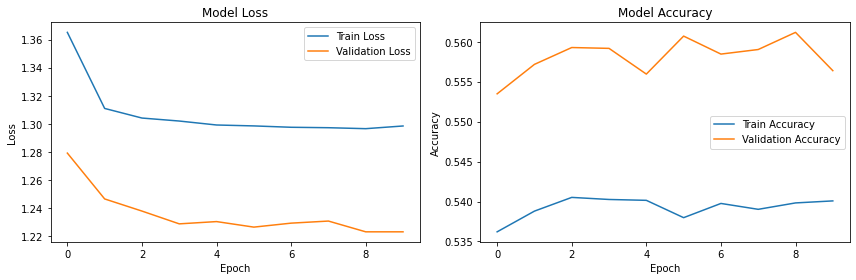

In [22]:
### Train the model
train_losses, val_losses, train_accuracies, val_accuracies, model = train_model(model_ft_f, train_loader, val_loader, criterion, optimizer)

### We will save the model, in part 2 we gonna use it!
torch.save(model_ft_f.state_dict(), 'BDD_weights_full_dataset_transfer.pth')

### Plot results. This is a naive plot, you are encouraged to improve it!
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

### Questions
1. [5 points] What did you observe from the two approaches? Does finetuning really train faster in this case?
Sol Yes I have Observed that the fine tuning really helps a lot it made a siginificant difference in test acurracy.
2. [5 points] In the above implemetation, the whole model is finetuned to downstream task. Can we just finetune the last fc layer? That is, can we freeze all the weights except the last fc layer during training? Please implement it and analyze the performance.
Sol) We Can finetun last layer but the performance is not good an dthe accuracy is not improving which is stucking.

In [23]:
############################### Test Data Loader ##############################
###############################################################################
#                                 Your code here                              #
###############################################################################

### If you don't want to train the model again, you can restore it!
model.load_state_dict(torch.load('BDD_weights_full_dataset_transfer.pth'))

# Change model to evaluation phase
model.eval()

# Function to get predictions and true labels
def get_predictions(model, dataloader):
    #############################################################
    #                      Your code here                       #
    #############################################################
    all_predictions = []
    all_labels = []
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    return np.array(all_predictions), np.array(all_labels)


### Get predictions and true labels
print(f"Test dataset size: {len(test_loader.dataset)}")

predictions, true_labels = get_predictions(model, test_loader)
print("Predictions:", predictions)
print("True labels:", true_labels)
################# Compute confusion matrix ##################
#############################################################
# cm = ?
cm = confusion_matrix(true_labels, predictions)
print("Confusion Matrix:")
print(cm)
#############################################################

### Calculate accuracy
accuracy = (predictions == true_labels).mean()
print(f"Test Accuracy: {accuracy:.4f}")

Test dataset size: 10000
Predictions: [0 0 0 ... 0 0 0]
True labels: [0 0 0 ... 6 6 6]
Confusion Matrix:
[[5254    0   26    0    1    1   64]
 [  13    0    0    0    0    0    0]
 [1085    0   67    0    0    0   87]
 [ 701    0   20    1    0    0   16]
 [ 666    0   14    0    7    0   51]
 [ 717    0   16    0    3    1   32]
 [ 972    0   17    1    2    1  164]]
Test Accuracy: 0.5494
